In [78]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np_utils
%matplotlib inline
np.random.seed(2017)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, MaxPooling1D
from keras.layers import Input, concatenate
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from data_science_utils.vision.keras import *
from time import time
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno as msno
import re
from joblib import Parallel, delayed
from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils
from data_science_utils import nlp as nlp_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols

import more_itertools
from more_itertools import flatten
import ast
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pwd
!nproc
!ls -ltrah price_prediction
!wc -l price_prediction/training.csv

In [4]:
df_train = pd.read_csv("price_prediction/training.csv")
df_test = pd.read_csv("price_prediction/public_test_features.csv")

In [ ]:
df_train.head()
df_test.head()


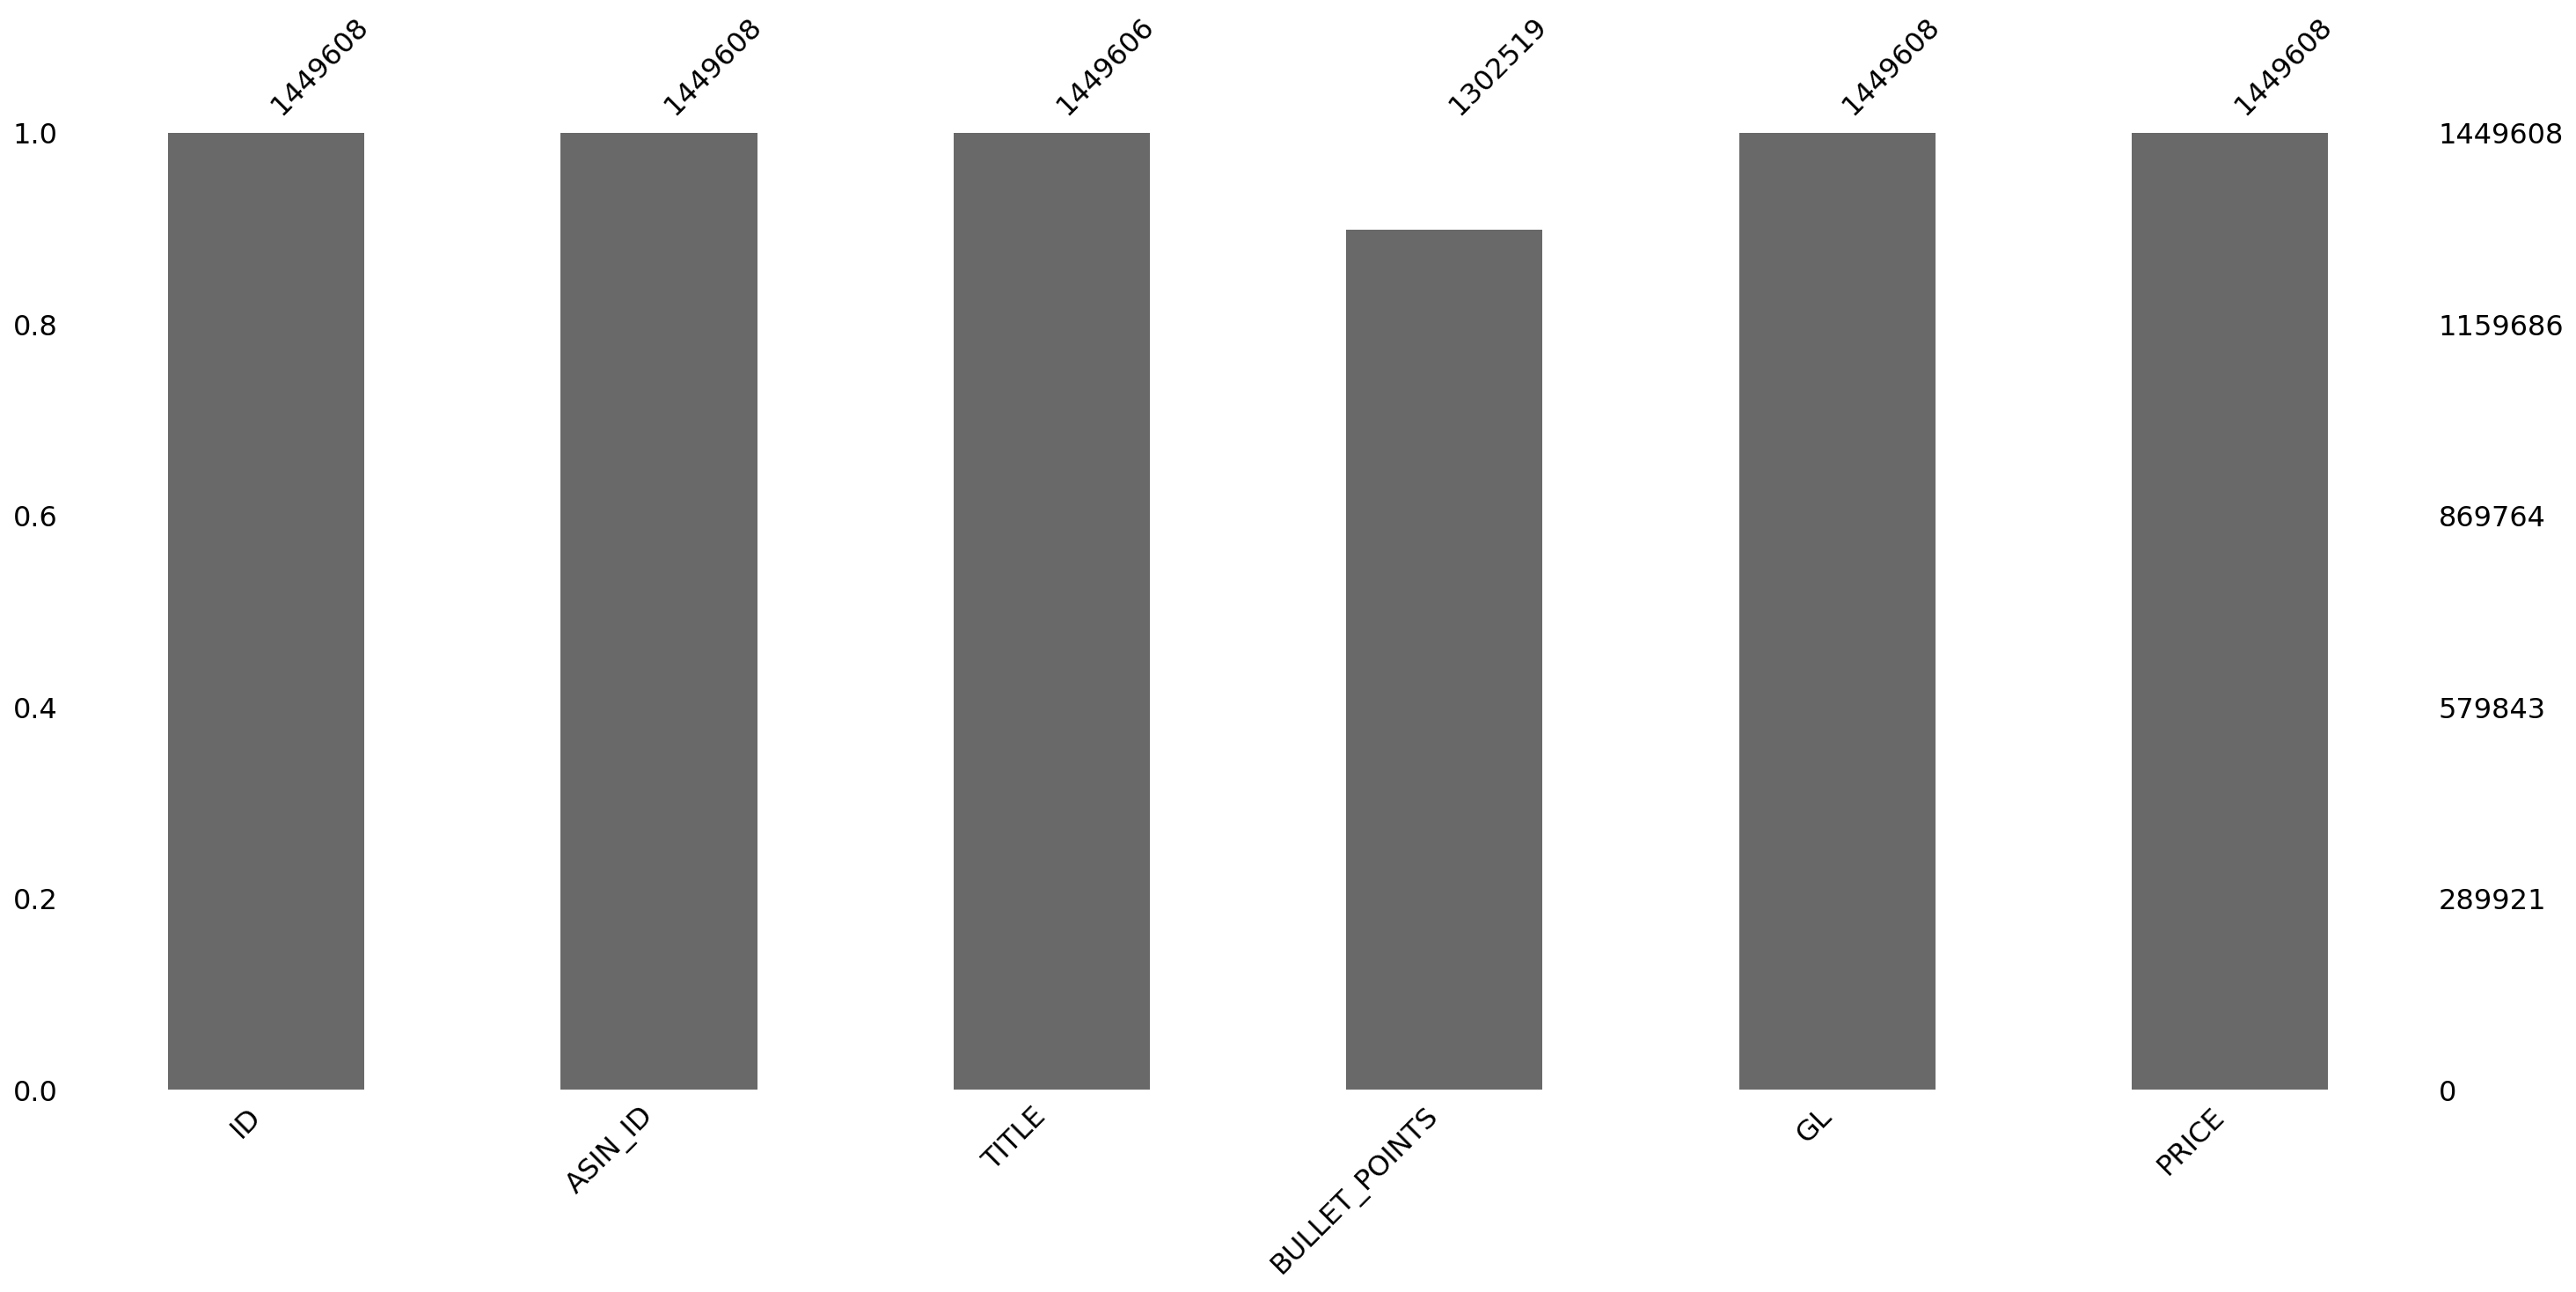

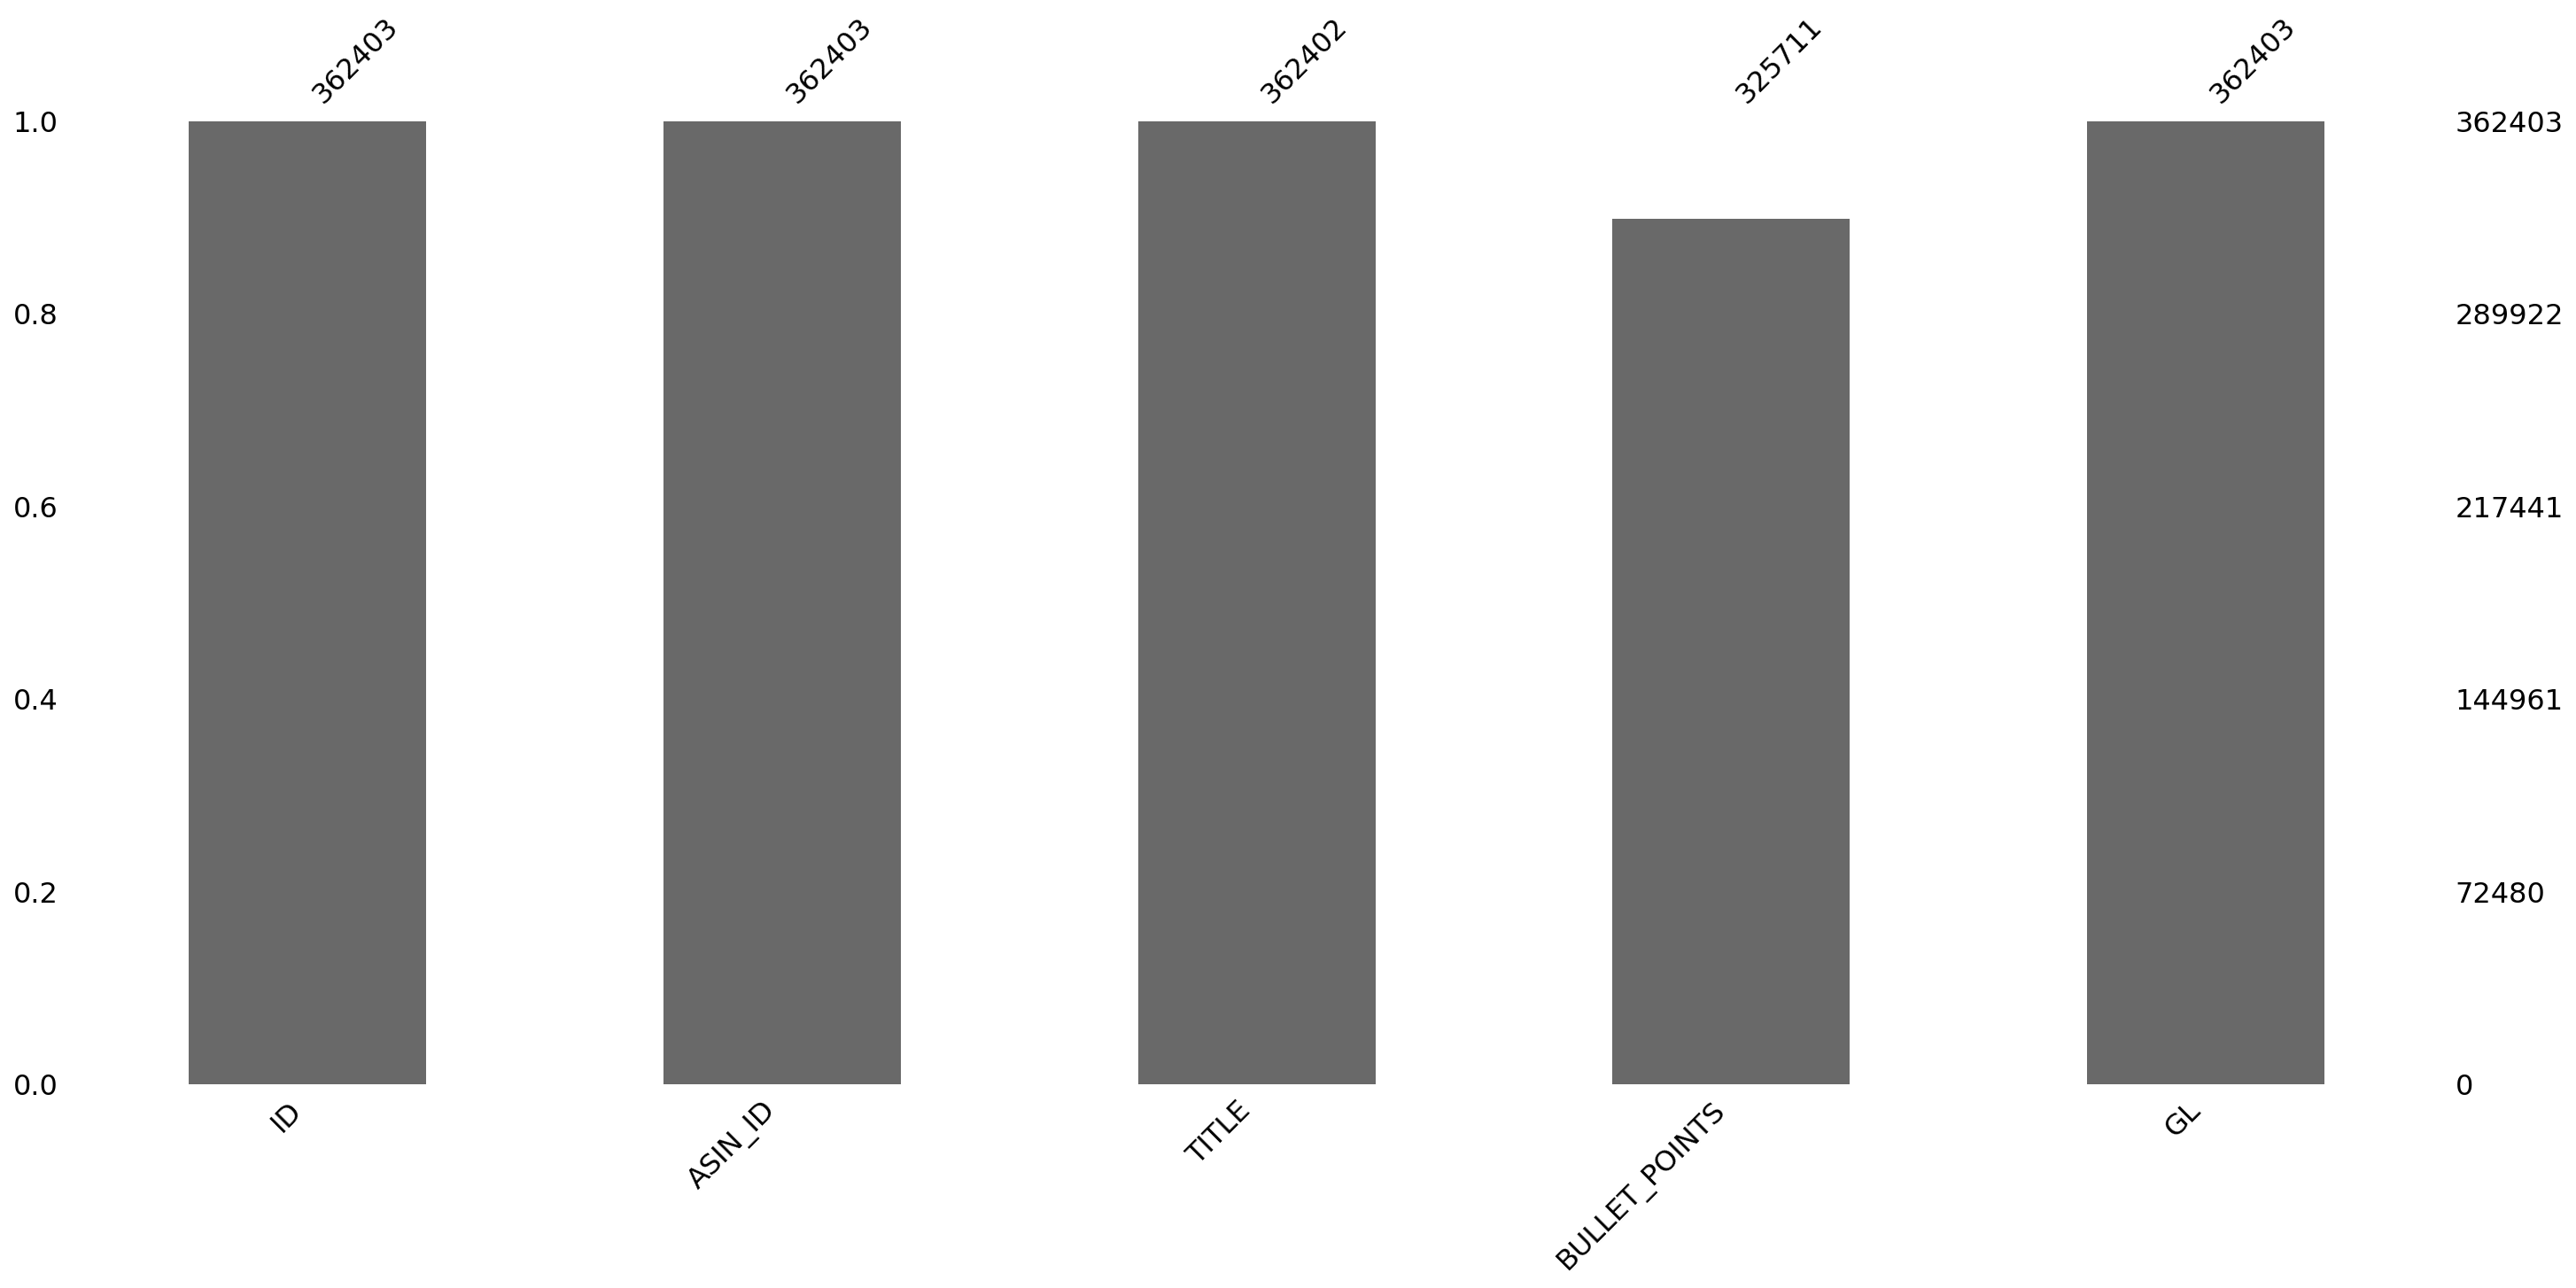

In [14]:
msno.bar(df_train)
msno.bar(df_test)

In [9]:
df_train.GL.nunique()
df_test.GL.nunique()

set(df_test.GL.unique()) - set(df_train.GL.unique())

61

56

{'gl_bill_payments', 'gl_digital_products_3_accessory', 'gl_kindle_unlimited'}

# Baseline
- GL Mean
- GL Median

In [15]:
df_gl_means = df_train.groupby(["GL"])[['PRICE']].mean().reset_index()

df_results = df_test.merge(df_gl_means, on=["GL"],how="left")
df_results = df_results[["ID","PRICE"]]
df_results["PRICE"] = df_results["PRICE"].fillna(df_results["PRICE"].mean())

df_results.head()

,ID,PRICE
0,1585751,772.612384
1,1530678,1290.724354
2,1324955,772.612384
3,822454,2321.772340
4,1604015,1115.235239


In [16]:
df_results.to_csv("baseline.csv",index=False)

# Preprocessing

In [17]:
df_train.columns

Index(['ID', 'ASIN_ID', 'TITLE', 'BULLET_POINTS', 'GL', 'PRICE'], dtype='object')

## Text encoder

In [53]:
import numpy as np
from collections import Counter
from tqdm import tqdm_notebook as tqdm

def build_dict(data, vocab_size = 50000,min_count=5):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    word_count = Counter() # A dict storing the words that appear in the reviews along with how often they occur
    for sentence in tqdm(data):
        word_count.update(sentence)
    
    print("Total Words before Min frequency filtering",len(word_count))
    sorted_words = [word for word,freq in word_count.most_common() if freq>=min_count]
    print("Total Words after Min frequency filtering",len(sorted_words))
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [46]:
def get_text_le(colname="GL"):
    le = {}
    INFREQ = 1
    NOWORD = 0
    UNKNOWN_TOKEN = '<unknown>'
    def le_train(df):
        le['wd'] = build_dict(df[colname].values)
        return le['wd']
    
    def word2label(word):
        word_dict = le['wd']
        if word in word_dict:
            return word_dict[word]
        else:
            return INFREQ
    def wordarray2labels(wordarray):
        return list(map(word2label,wordarray))
    def le_transform(df):
        word_list = [wordarray2labels(x) for x in tqdm(df[colname])]
        return word_list
        
    return le_train,le_transform, le

In [47]:
def get_le(colname="GL"):
    le = LabelEncoder()
    UNKNOWN_TOKEN = '<unknown>'
    def le_train(df):
        return le.fit(list(df[colname])+[UNKNOWN_TOKEN])
    def le_transform(df):
        uniq_labels = set(le.classes_)
        return le.transform(df[colname].apply(lambda label:label if label in uniq_labels else UNKNOWN_TOKEN))
    return le_train,le_transform, le

In [17]:
gl_le_train,gl_le_transform, le = get_le("GL")
gl_le_train(df_train)
gl_le_transform(df_train.head())
gl_le_transform(df_test)

LabelEncoder()

array([31, 17,  1,  1, 17])

array([ 1, 55,  1, ...,  1,  1, 17])

In [48]:
# preprocess_string = lambda x:re.sub('[^ a-zA-Z0-9%@_]',' ',nlp_utils.remove_html_tags(nlp_utils.clean_text(x))) if x is not None and type(x)==str else x

preprocess_string = lambda x:re.sub('[^ a-zA-Z0-9%@_]',' ',nlp_utils.clean_text(x)) if x is not None and type(x)==str else x



## For Word Embedding CNN
- Making a text column
    - append GL
    - replace num
    - replace measurement
    
- Hyper Params here:
    - Stopwords
    - word_length_filter
    - lemmatize or not
    - vocab_size in build_dict
    
    
    


In [49]:


def preprocess_for_word_cnn(df,text_columns=['TITLE', 'BULLET_POINTS', 'GL'], output_column="text",jobs=40):
    """
    Preprocess and convert all text columns to one column named text
    """
    pp = lambda text: nlp_utils.combined_text_processing(preprocess_string(text))
    df['text'] = df['TITLE'].fillna(' ') + df['BULLET_POINTS'].fillna(' ') + df['GL'].fillna(' ')
    # titles = Parallel(n_jobs=jobs, backend="loky")(delayed(pp)(x) for x in df['TITLE'].values)
    # bullet_points = Parallel(n_jobs=jobs, backend="loky")(delayed(pp)(x) for x in df['BULLET_POINTS'].values)
    # gls = Parallel(n_jobs=jobs, backend="loky")(delayed(pp)(x) for x in df['GL'].values)
    # df['text'] = pd.Series(titles)+pd.Series(bullet_points)+pd.Series(gls)
    
    text = Parallel(n_jobs=jobs, backend="loky")(delayed(pp)(x) for x in tqdm(df['text'].values))
    df['text'] = text
    return df
    
    

In [52]:
start = time()
print("Preprocessing start.",(time()-start))
df_train_slice = preprocess_for_word_cnn(df_train.head(10000),jobs=20)
print("Preprocessing done.",(time()-start))
gl_le_train,gl_le_transform, le = get_text_le("text")
_ = gl_le_train(df_train_slice)
print("LE training done.",(time()-start))
df_train_slice['text_encoded'] = gl_le_transform(df_train_slice)
print("LE transform done",(time()-start))
df_train_slice.head()

Preprocessing start. 3.5762786865234375e-05


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Preprocessing done. 11.004846334457397


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Total Words before Min frequency filtering 21952
Total Words after Min frequency filtering 5380
LE training done. 11.19306492805481



LE transform done 14.86776089668274


,ID,ASIN_ID,TITLE,BULLET_POINTS,GL,PRICE,text,text_encoded
0,1489960,B07HNQBLZH,"Livsmart Resin Jewellery Display Stand, 17x11c...",[Holds rings and other small items especially ...,gl_jewelry,507.62,"[livsmart, resin, jewellery, display, stand, _...","[1, 1375, 248, 340, 193, 8, 4, 33, 544, 278, 1..."
1,633493,B00MTZ726Y,Quantum Creation: Does the Supernatural Lurk i...,NaN,gl_digital_ebook_purchase,479.90,"[quantum, creation, supernatural, lurk, fourth...","[1, 822, 1, 1, 4315, 206, 266]"
2,1474591,B015MZ3NJW,IZOD Men's Casual Shirt (8907163477392_ZKSH019...,"[Cotton linen,Cotton linen shirt,Checkered pat...",gl_apparel,829.28,"[izod, men, casual, shirt, _NUM30_, _zksh, _NU...","[4783, 23, 37, 32, 115, 1, 59, 3226, 9, 967, 9..."
3,830218,B079DNYB4N,"Dishaa Women's Rayon A-Line Kurta (Black, X-La...","[Material: Rayon,Color: Black ; Work: Threaded...",gl_apparel,648.31,"[dishaa, woman, rayon, line, kurta, black, lar...","[1, 20, 555, 184, 209, 33, 135, 2055, 413, 712..."
4,201144,B00XHH7LBY,Return of the Ravens (Ulfrik Ormsson's Saga Bo...,NaN,gl_digital_ebook_purchase,332.00,"[return, raven, ulfrik, ormsson, saga, book, _...","[780, 1, 1, 1, 1, 676, 2, 266]"


## Transforming Full DataSet

In [ ]:
start = time()
print("Preprocessing start.",(time()-start))
df_train = preprocess_for_word_cnn(df_train,jobs=20)
print("Preprocessing done.",(time()-start))
gl_le_train,gl_le_transform, le = get_text_le("text")
_ = gl_le_train(df_train)
print("LE training done.",(time()-start))
df_train['text_encoded'] = gl_le_transform(df_train)
print("LE transform done",(time()-start))
df_train.head()

Preprocessing start. 6.0558319091796875e-05


In [ ]:
start = time()
print("Preprocessing start.",(time()-start))
df_test = preprocess_for_word_cnn(df_test,jobs=20)
print("LE training done.",(time()-start))
df_test['text_encoded'] = gl_le_transform(df_test)
print("LE transform done",(time()-start))
df_test.head()

# Baseline 2: Keras Imdb Model

In [ ]:
from __future__ import print_function


# set parameters:
max_features = 50000
maxlen = 100
batch_size = 256
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 5

print('Loading data...')

X,y = df_train['text_encoded'].values,df_train['PRICE'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae','mse'])
model.count_params()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))



1159686/1159686 [==============================] - 341s 294us/step - loss: 4033933786.3938 - mean_absolute_error: 894.5309 - val_loss: 16347761.4813 - val_mean_absolute_error: 716.5794
Epoch 2/5
1159686/1159686 [==============================] - 340s 293us/step - loss: 4032204864.3942 - mean_absolute_error: 822.3543 - val_loss: 15832785.5048 - val_mean_absolute_error: 704.4332
Epoch 3/5
1159686/1159686 [==============================] - 339s 292us/step - loss: 4031421547.0617 - mean_absolute_error: 794.2296 - val_loss: 15649164.7560 - val_mean_absolute_error: 698.5270
Epoch 4/5
1159686/1159686 [==============================] - 341s 294us/step - loss: 4030308633.8232 - mean_absolute_error: 781.7042 - val_loss: 15564212.7209 - val_mean_absolute_error: 678.7286
Epoch 5/5
1159686/1159686 [==============================] - 342s 295us/step - loss: 4028990347.3919 - mean_absolute_error: 773.1664 - val_loss: 15462277.1944 - val_mean_absolute_error: 689.7498


In [ ]:
X_test = df_test['text_encoded'].values
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_preds = model.predict(X_test)

df_results = df_test[['ID']]
df_results['PRICE'] = y_preds

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
df_results.head()
df_results.to_csv("baseline-2.csv",index=False)

,ID,PRICE
0,1585751,402.462646
1,1530678,708.144775
2,1324955,199.348129
3,822454,2087.896729
4,1604015,637.491211


In [61]:
model.count_params()

model.summary()

2600751

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           2500000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 250)               0         
__________

# Embedding Model

In [65]:

def conv_layer(inputs, n_kernels=32, kernel_size=3, dropout=0.1,dilation_rate=1, padding='valid'):
    out = Conv1D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate)(inputs)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Dropout(dropout)(out)
    return out

def transition_layer(inputs, n_kernels=32,dropout=0):
    out = conv_layer(inputs, n_kernels, kernel_size=1,dropout=dropout, padding='same')
    return out

def pre_dense_layer(inputs):
    out1 = GlobalAveragePooling1D()(inputs)
    out2 = GlobalMaxPooling1D()(inputs)
    out = concatenate([out1,out2])
    return out

def grouped_layer(inputs, group_configs, out_channels):
    groups = []
    for group_config in group_configs:
        out1 = inputs
    for layer_config in group_config:
        out1 = conv_layer(out1, **layer_config)
    groups.append(out1)
    y = concatenate(groups)
    y = transition_layer(y, out_channels)
    return y

In [ ]:
max_features = 50000
maxlen = 100
batch_size = 4096
embedding_dims = 50
epochs = 5


X,y = df_train['text_encoded'].values,df_train['PRICE'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

inputs = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = Embedding(output_dim=embedding_dims, input_dim=max_features, input_length=maxlen)(inputs)
K.int_shape(x)
x = conv_layer(x,n_kernels=64,kernel_size=5,padding='valid')
x = conv_layer(x,n_kernels=128,kernel_size=3,padding='valid')
x = transition_layer(x, n_kernels=64,dropout=0)
x = MaxPooling1D()(x)
x = conv_layer(x,n_kernels=128,kernel_size=3,padding='valid')
x = conv_layer(x,n_kernels=256,kernel_size=3,padding='valid')
x = transition_layer(x, n_kernels=64,dropout=0)



xp = pre_dense_layer(x)
K.int_shape(x)
print(K.int_shape(xp))
x = Dense(128)(xp)
x = Dropout(0.2)(x)
x = Activation('relu')(x)
K.int_shape(x)
output = Dense(1)(x)

model = Model(inputs=inputs, outputs=output)


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae','mse'])
print(model.count_params())

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))



# Pretrained Embeddings

In [93]:
start = time()
model = api.load("glove-twitter-25") 
print("total = ",(time()-start))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


total =  46.830612897872925


In [94]:
start = time()
fasttext = api.load("fasttext-wiki-news-subwords-300") 
print("total = ",(time()-start))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


total =  322.69476318359375


In [116]:
class PreTrainedEmbeddingsTransformer:
    def __init__(self,model="fasttext-wiki-news-subwords-300",size=300,
                 normalize_word_vectors=True):
        self.normalize_word_vectors = normalize_word_vectors
        self.model = model
        self.size = size
        
    def fit(self, X=None, y='ignored'):
        if type(self.model) == str:
            self.model = api.load(self.model) 

    def partial_fit(self, X=None, y=None):
        self.fit(X, y='ignored')

    def transform(self, X, y='ignored'):
        print("Fasttext Transforms start at: %s" % (str(pd.datetime.now())))
        uniq_tokens = set(more_itertools.flatten(X))
        print("Number of Unique Test Tokens for Fasttext transform %s"%len(uniq_tokens))
        empty = np.full(self.size, 0)
        token2vec = {k: self.model.wv[k] if k in self.model.wv else empty for k in uniq_tokens}
        token2vec = {k: v / np.linalg.norm(v) for k, v in token2vec.items()}


        def tokens2vec(token_array):
            empty = np.full(self.size, 0)
            if len(token_array) == 0:
                return empty
            return [token2vec[token] if token in uniq_tokens else empty for token in token_array]

        # ft_vecs = list(map(tokens2vec, X))
        ft_vecs = [np.nan_to_num(np.array(tokens2vec(t))) for t in tqdm(X)]
        ft_vecs = np.array(ft_vecs)
        print("Fasttext Transforms done at: %s" % (str(pd.datetime.now())))
        return ft_vecs

    def inverse_transform(self, X, copy=None):
        raise NotImplementedError()

    def fit_transform(self, X, y='ignored'):
        self.fit(X)
        return self.transform(X)


In [117]:
ptr = PreTrainedEmbeddingsTransformer(fasttext,size=300)
ptr.fit()
arr = ptr.transform(df_train['text'].head(2).values)
arr.shape


Fasttext Transforms start at: 2019-06-12 15:49:58.632693
Number of Unique Test Tokens for Fasttext transform 40


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide



Fasttext Transforms done at: 2019-06-12 15:49:58.661329


(2,)

In [ ]:
maxlen = 100
batch_size = 4096
embedding_dims = 300
epochs = 5


X,y = ptr.transform(df_train['text'].values),df_train['PRICE'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


Fasttext Transforms start at: 2019-06-12 15:50:49.517983
Number of Unique Test Tokens for Fasttext transform 332242


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


In [113]:

inputs = Input(shape=(None,embedding_dims), dtype='int32', name='main_input')

x = conv_layer(x,n_kernels=64,kernel_size=5,padding='valid')
x = conv_layer(x,n_kernels=128,kernel_size=3,padding='valid')
x = transition_layer(x, n_kernels=64,dropout=0)
x = MaxPooling1D()(x)
x = conv_layer(x,n_kernels=128,kernel_size=3,padding='valid')
x = conv_layer(x,n_kernels=256,kernel_size=3,padding='valid')
x = transition_layer(x, n_kernels=64,dropout=0)


xp = pre_dense_layer(x)
x = Dense(128)(xp)
x = Dropout(0.2)(x)
x = Activation('relu')(x)
K.int_shape(x)
output = Dense(1)(x)

model = Model(inputs=inputs, outputs=output)


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae','mse'])
print(model.count_params())

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))



ValueError: Input 0 is incompatible with layer conv1d_44: expected ndim=3, found ndim=2

# Post Processing
- gl min max clipping
- max(0,output)